# Exercise 2.05

In [1]:
import tensorflow as tf
import os

In [2]:
def load_audio(file_path, sample_rate=44100):
    # Load audio at 44.1kHz sample-rate
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio,
                                             desired_channels=-1,
                                             desired_samples=sample_rate)
    return tf.transpose(audio)

In [3]:
prefix = "../Datasets/data_speech_commands_v0.02/zero/"
paths = [os.path.join(prefix, path) for path in os.listdir(prefix)]

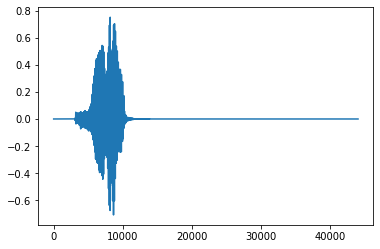

In [4]:
import matplotlib.pyplot as plt
audio = load_audio(paths[0])
plt.plot(audio.numpy().T)

In [5]:
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256,
                           fft_length=1024)
    spectrograms = tf.abs(stfts)
    num_spectrogram_bins = stfts.shape[-1]#.value
    
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :num_mfccs]
    return mfccs

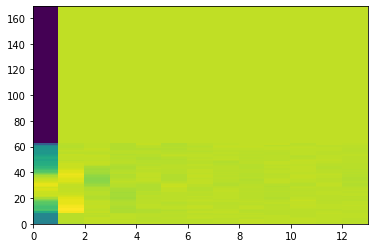

In [6]:
mfcc = apply_mfccs(audio)
plt.pcolor(mfcc.numpy()[0])

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prep_ds(ds, shuffle_buffer_size=1024, batch_size=64):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Load and decode audio from file paths
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    # generayte MFCCs from the audio data
    ds = ds.map(apply_mfccs)
    # Repeat dataset forever
    ds = ds.repeat()
    # Prepare batches
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [8]:
ds = tf.data.Dataset.from_tensor_slices(paths)
train_ds = prep_ds(ds)

Take 1 batch and print it out

In [9]:
for x in train_ds.take(1):
    print(x)

tf.Tensor(
[[[[-1.63207493e+01 -1.30399179e+00  3.63255572e+00 ... -8.81270349e-01
    -1.04995263e+00 -2.28330684e+00]
   [-2.37950077e+01 -1.39360023e+00  2.16576815e+00 ...  3.57407719e-01
    -1.27397525e+00 -1.74753749e+00]
   [-2.42810955e+01  7.08627403e-01  1.58718014e+00 ...  3.52883101e-01
    -1.58700347e+00 -2.59117913e+00]
   ...
   [-1.74754272e+02 -7.82595671e-05  8.29657256e-06 ...  8.80490370e-06
     6.48393325e-06 -2.29595958e-06]
   [-1.74754272e+02 -7.82595671e-05  8.29657256e-06 ...  8.80490370e-06
     6.48393325e-06 -2.29595958e-06]
   [-1.74754272e+02 -7.82595671e-05  8.29657256e-06 ...  8.80490370e-06
     6.48393325e-06 -2.29595958e-06]]]


 [[[-4.29330063e+01 -6.88680458e+00 -2.16700935e+00 ...  6.69247866e-01
     7.86118269e-01  9.28699225e-02]
   [-4.36671753e+01 -7.72747707e+00 -2.73828793e+00 ...  1.42105818e+00
     4.28844780e-01 -7.35874116e-01]
   [-4.31410255e+01 -6.36055565e+00 -1.90095127e+00 ...  1.94981694e+00
     8.23285401e-01 -5.33023059e-0